In [136]:
from mplsoccer.pitch import Pitch, VerticalPitch
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from highlight_text import HighlightText, ax_text, fig_text
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
import matplotlib.patheffects as path_effects

In [137]:
data = pd.read_csv("PL 23-24 WS Events.csv" , low_memory=False)
data['x'] = data['x']*1.2
data['y'] = data['y']*.8
data['endX'] = data['endX']*1.2
data['endY'] = data['endY']*.8

In [138]:
cmap_lst = ['#131313', '#24a8ff', '#0d4163'] 
cmap=LinearSegmentedColormap.from_list('test',cmap_lst, N=256) 

In [139]:
data['total_seconds'] = data['minute'] * 60 + data['second']

In [140]:
# Define the function to calculate TTRP
def calculate_ttrp(data):
    # Initialize the new column with NaNs
    data['TTRP'] = np.nan
    
    # Define the preceding action types
    preceding_action_types = ['Aerial', 'BallRecovery', 'Tackle', 'TakeOn', 'Interception', 'Pass']
    
    # Filter data to get relevant actions
    relevant_actions = data[data['type'].isin(preceding_action_types)].copy()
    
    # Sort the data by gameId and total_seconds to ensure proper order
    relevant_actions.sort_values(by=['gameId', 'total_seconds'], inplace=True)
    
    # Create a shift column to get the previous action's time, type, and playerId within the same game
    relevant_actions['prev_total_seconds'] = relevant_actions.groupby('gameId')['total_seconds'].shift(1)
    relevant_actions['prev_type'] = relevant_actions.groupby('gameId')['type'].shift(1)
    relevant_actions['prev_playerId'] = relevant_actions.groupby('gameId')['playerId'].shift(1)
    
    # Filter only the passes
    passes = data[data['type'] == 'Pass'].copy()
    
    # Merge passes with relevant actions to get the preceding action details
    passes = passes.merge(
        relevant_actions[['gameId', 'playerId', 'total_seconds', 'prev_total_seconds', 'prev_type', 'prev_playerId']],
        how='left',
        left_on=['gameId', 'playerId', 'total_seconds'],
        right_on=['gameId', 'playerId', 'total_seconds']
    )
    
    # Calculate TTRP for valid preceding actions
    passes['TTRP'] = np.where(
        ((passes['prev_type'] == 'Pass') & (passes['prev_playerId'] != passes['playerId'])) |
        ((passes['prev_type'] != 'Pass') & (passes['prev_playerId'] == passes['playerId'])),
        passes['total_seconds'] - passes['prev_total_seconds'],
        np.nan
    )
    
    # Merge TTRP back to the original data
    data = data.merge(passes[['gameId', 'playerId', 'total_seconds', 'TTRP']], 
                      how='left', 
                      on=['gameId', 'playerId', 'total_seconds'], 
                      suffixes=('', '_y'))
    
    # Fill TTRP column
    data['TTRP'] = data['TTRP'].combine_first(data['TTRP_y'])
    data.drop(columns=['TTRP_y'], inplace=True)
    
    return data

# Apply the function
data = calculate_ttrp(data)


In [141]:
data_passes = data[data['type']=='Pass']

In [142]:
data_fast_passes = data_passes[(data_passes['TTRP'] == 2) & (data_passes['player'] == 'Trent Alexander-Arnold')]

In [143]:
data_fast_passes_succ = data_fast_passes[data_fast_passes['outcomeType'] == 'Successful']
data_fast_passes_unsucc = data_fast_passes[data_fast_passes['outcomeType'] == 'Unsuccessful']
#data_fast_passes_unsucc

In [144]:
data_fast_passes_succ_prog = data_fast_passes_succ.reset_index()
#data_unsucc_prog = data_unsucc.reset_index()
data_fast_passes_succ_prog['beginning'] = np.sqrt(np.square(120-data_fast_passes_succ_prog['x']) + np.square(40 - data_fast_passes_succ_prog['y']))
data_fast_passes_succ_prog['end'] = np.sqrt(np.square(120 - data_fast_passes_succ_prog['endX']) + np.square(40 - data_fast_passes_succ_prog['endY']))

data_fast_passes_succ_prog['progressive'] = [(data_fast_passes_succ_prog['end'][x]) / (data_fast_passes_succ_prog['beginning'][x]) < .75 for x in range(len(data_fast_passes_succ_prog.beginning))]
data_fast_passes_succ_prog = data_fast_passes_succ_prog[data_fast_passes_succ_prog['progressive'] == True]

In [145]:
prog_pass = data_fast_passes_succ_prog['x'].count()
fast_pass_succ = data_fast_passes_succ['x'].count()
fast_pass_unsucc = data_fast_passes_unsucc['x'].count()
pass_acc = ((fast_pass_succ/(fast_pass_succ+fast_pass_unsucc))*100).round(2)
pass_acc

79.17

In [146]:
percent_of = ((prog_pass/fast_pass_succ)*100).round(2)

In [147]:
#player_name = data_fast_passes['player'].unique()

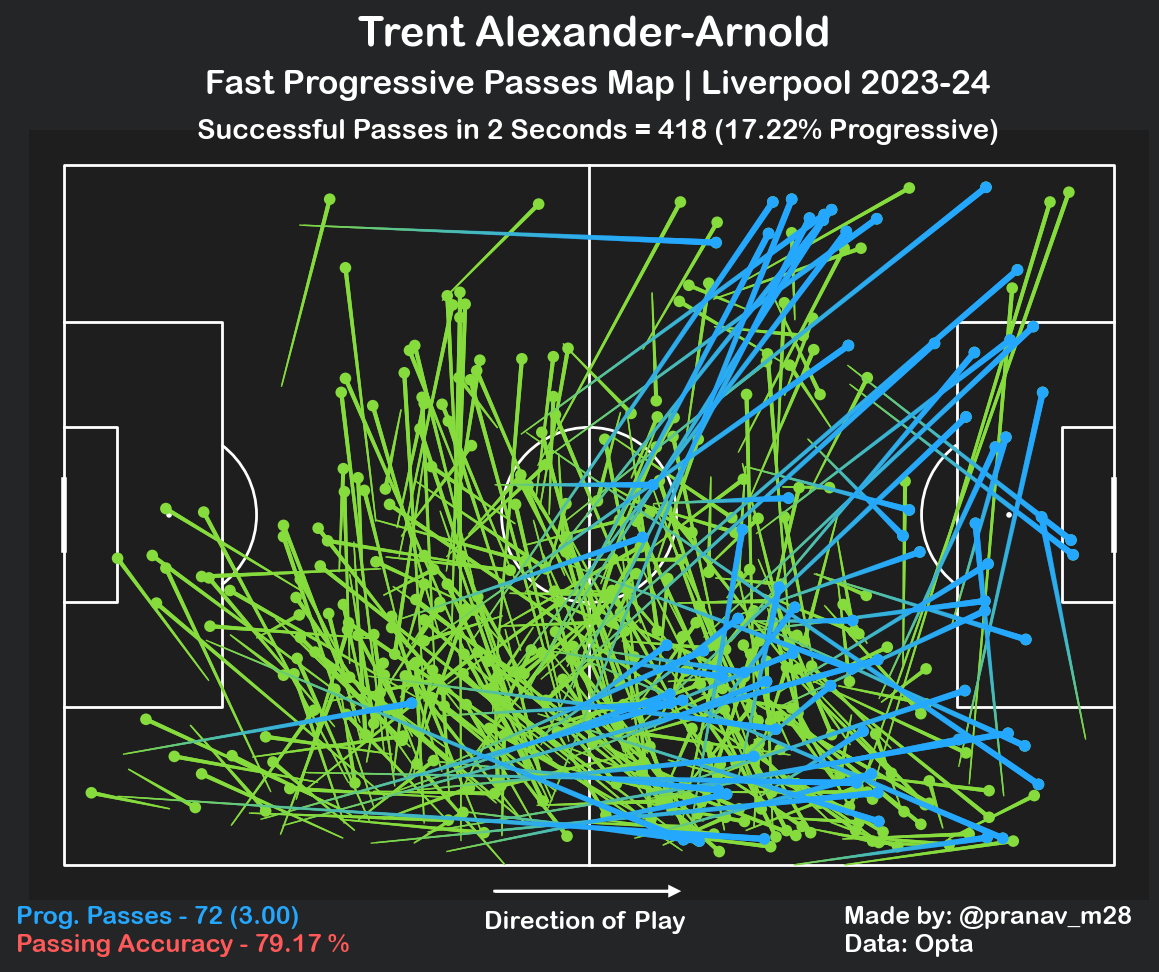

In [154]:
fig ,ax = plt.subplots(figsize=(15.5,10))
fig.set_facecolor('#242526')
ax.patch.set_facecolor('#242526')

pitch = Pitch(pitch_type='statsbomb',
              pitch_color='#1e1e1e', line_color='#FFFFFF')

pitch.draw(ax=ax)

#Plotting Progressive Passes

lc1 = pitch.lines(data_fast_passes_succ_prog.x, data_fast_passes_succ_prog.y,
                  data_fast_passes_succ_prog.endX, data_fast_passes_succ_prog.endY,
                  lw=4.5, transparent=True, comet=True, label='completed passes',
                  color='#24a8ff', ax=ax)

pitch.scatter(data_fast_passes_succ_prog.endX, data_fast_passes_succ_prog.endY, s=70,
              marker='o', edgecolors='none', c='#24a8ff', zorder=2,
              label='goal', ax=ax , alpha=1)


#Plotting Successful Passes

lc1 = pitch.lines(data_fast_passes_succ.x, data_fast_passes_succ.y,
                  data_fast_passes_succ.endX, data_fast_passes_succ.endY,
                  lw=3, transparent=False, comet=True, label='completed passes', zorder=1,
                  color='#86dc3d', ax=ax)

pitch.scatter(data_fast_passes_succ.endX, data_fast_passes_succ.endY, s=70,
              marker='o', edgecolors='none', c='#86dc3d', zorder=1,
              label='goal', ax=ax , alpha=1)

plt.gca().invert_yaxis()


fig_text(
    0.516, 0.995, f"<Trent Alexander-Arnold>", font='Arial Rounded MT Bold' ,size=30,
    ha="center", color="#FFFFFF" , fontweight='bold' , highlight_textprops=[{"color": '#FFFFFF'}]
)

fig_text(
    0.518, 0.941,
    "Fast Progressive Passes Map | Liverpool 2023-24",
    font='Arial Rounded MT Bold' ,size=24,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

fig_text(
    0.518, 0.892,
    f"Successful Passes in 2 Seconds = {fast_pass_succ} ({percent_of}% Progressive)",
    font='Arial Rounded MT Bold' ,size=20,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

fig_text(
    0.770, 0.105, "Made by: @pranav_m28\nData: Opta", font='Arial Rounded MT Bold' ,size=18,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

fig_text(
    0.250, 0.105, f"<Prog. Passes - {prog_pass} (3.00)>\n<Passing Accuracy - {pass_acc} %>", font='Arial Rounded MT Bold' ,size=18,
    ha="center", color="#FFFFFF" , fontweight='bold' , highlight_textprops=[{"color": '#24a8ff'} , {"color": '#FF5959'}]
)

plt.style.use("dark_background")
mpl.rc('axes',edgecolor='#131313' , linewidth=1.2)
for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#1e1e1e' 
for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '0.9'


fig_text(
    0.510, 0.10, "Direction of Play", font='Arial Rounded MT Bold' ,size=18,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

plt.arrow(49.2 , -3 , 20 , 0 , fc='#FFFFFF' , ls='-' , lw=1.9 , head_length=1 , head_width=1)

#plt.savefig('Trent TTRP=2 Map.png' , dpi=300 , bbox_inches='tight')

In [150]:
prog_pass/(24.01)

2.99875052061641